# Project - Cat vs Non-cat Classifier

## Description
Dataset is located at `/cxldata/datasets/project/cat-non-cat`

Dataset is in .h5 file. Import h5py to interact with a dataset that is stored in an H5 file. It contains

+ train_catvnoncat.h5 - a training set of 209 images labeled as cat (y=1) or non-cat (y=0)
+ test_catvnoncat.h5 - a test set of 50 images labeled as cat or non-cat
+ Each image is of shape (64, 64, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = 64 pixels) and (width = 64 pixels)

## Guidelines
Build and train a **neural network** to classify the given image as cat or non-cat. **You can either use logistic regression or CNN.**

After you are done, save your notebook as `cat_vs_noncat_classifier.ipynb` inside `cloudxlab_jupyter_notebooks` directory in your home folder on CloudxLab.

In [1]:
# Importing dependencies

import numpy as np
import matplotlib.pyplot as plt
import h5py
from PIL import Image
%matplotlib inline
import tensorflow as tf

In [2]:
# Function to reset graph and give default seed

def reset_graph(seed=20):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Importing dataset

In [29]:
# Training dataset - composed of 209 images of dimension 64x64 with 3 color channels (RGB)
train_dataset = h5py.File('/cxldata/datasets/project/cat-non-cat/train_catvnoncat.h5', 'r')
train_set_x_orig = np.array(train_dataset['train_set_x'][:])
train_set_y_orig = np.array(train_dataset['train_set_y'][:])

# Test dataset - composed of 50 images of dimension 64x64 with 3 color channels (RGB)
test_dataset = h5py.File('/cxldata/datasets/project/cat-non-cat/test_catvnoncat.h5', 'r')
test_set_x_orig = np.array(test_dataset['test_set_x'][:])
test_set_y_orig = np.array(test_dataset['test_set_y'][:])

# Listing classes - 0 for non-cat and 1 for cat
classes = np.array(test_dataset['list_classes'][:])

# Converting labels to two dimensional array
train_set_y = train_set_y_orig.reshape(1, train_set_y_orig.shape[0])
test_set_y = test_set_y_orig.reshape(1, test_set_y_orig.shape[0])

# Converting colored images to grayscale
train_set_x = np.mean(train_set_x_orig, -1)
test_set_x = np.mean(test_set_x_orig, -1)

In [30]:
print(train_set_x_orig.shape)
train_set_x.shape

(209, 64, 64, 3)


(209, 64, 64)

[1]
cat


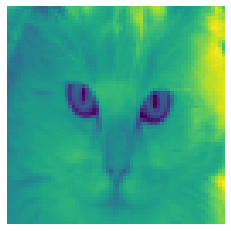

In [31]:
# Visualise a sample image

index = 50 # change this to see a different image
plt.imshow(train_set_x[index])
plt.axis('off')
y = train_set_y[:,index]
y_class = classes[np.squeeze(train_set_y[:, index])].decode('utf-8')
print(y)
print(y_class)

DNN Strategy
-------------------
1. He Initialisation
2. Activation - SELU (ELU recommended)
3. Batch Normalization / Dropout
4. Adam Optimizer

In [8]:
height = 64
width = 64
channels = 1 
n_inputs = height * width # 4096

# No. of neurons in each of the layers
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 1
learning_rate = 0.01
momentum = 0.9 # for batch normalization

In [9]:
# Constructing deep neural network

reset_graph()

from functools import partial

with tf.name_scope('inputs'):
    X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name='X') # => [-1, 64, 64]
    y = tf.placeholder(tf.int64, shape=[1, None], name='y') # => [1, -1]
#     y = tf.reshape(y, shape=[-1, 1, 1])

training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope('dnn'):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    
    # Using partial function to avoid code duplication
    batch_norm_layer = partial(tf.layers.batch_normalization, training=training, 
                               momentum=momentum)
    dense_layer = partial(tf.layers.dense, kernel_initializer=he_init)
    # ----------------------------------------------------------------
    
    hidden1 = dense_layer(X, n_hidden1, name='hidden1', activation=tf.nn.selu)
#     bn1 = batch_norm_layer(hidden1)
#     bn1_act = tf.nn.selu(bn1)
    
    hidden2 = dense_layer(hidden1, n_hidden2, name='hidden2', activation=tf.nn.selu)
#     bn2 = batch_norm_layer(hidden2)
#     bn2_act = tf.nn.selu(bn2)

with tf.name_scope('outputs'):
    logits = tf.layers.dense(hidden2, n_outputs, name='outputs') # logits_before_bn
#     logits_flat = tf.reshape(logits_before_bn, shape=[-1, 64, 64])
#     logits = batch_norm_layer(logits_before_bn) --- >
#     logits = tf.reshape(logits, shape=[-1, 64])
#     logits = tf.concat((1-logits, logits), axis=2)

    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
#     xentropy = tf.losses.log_loss(labels=y, predictions=logits) # log loss for binary classification
    loss = tf.reduce_mean(xentropy, name='loss')

with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer() # could add learning rate - 0.01
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1) # logits=prediction(rank-2), y=target (rank-1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

ValueError: Rank mismatch: Rank of labels (received 2) should equal rank of logits minus 1 (received 4).

ValueError: Rank mismatch: Rank of labels (received 2) should equal rank of logits minus 1 (received 4).

Shape must be rank 1 but is rank 2 for 'eval/in_top_k/InTopKV2' (op: 'InTopKV2') with input shapes: [?,64], [1,?], [].

In [10]:
tf.losses.log_loss?

W0831 10:13:03.985916 139842100893504 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:1732: The name tf.losses.log_loss is deprecated. Please use tf.compat.v1.losses.log_loss instead.



In [67]:
n_epochs = 10

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        sess.run([training_op, extra_update_ops], 
                 feed_dict={training: True, X: train_set_x, y: train_set_y})
        
        accuracy_train = accuracy.eval(feed_dict={X: train_set_x, y: train_set_y})
        accuracy_test = accuracy.eval(feed_dict={X: test_set_x, y: test_set_y})

        print(epoch, 'Train accuracy', accuracy_train, 'Test accuracy', accuracy_test)

InvalidArgumentError: assertion failed: [] [Condition x == y did not hold element-wise:] [x (loss/SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [1 209] [y (loss/SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [209 64]
	 [[node loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal/Assert/Assert (defined at <ipython-input-64-13e3c76f69a8>:37) ]]

Original stack trace for 'loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal/Assert/Assert':
  File "/usr/local/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/anaconda/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/local/anaconda/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/local/anaconda/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "/usr/local/anaconda/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/usr/local/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-64-13e3c76f69a8>", line 37, in <module>
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 3355, in sparse_softmax_cross_entropy_with_logits
    array_ops.shape(logits)[:-1]))
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/check_ops.py", line 557, in assert_equal
    return control_flow_ops.Assert(condition, data, summarize=summarize)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_should_use.py", line 193, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 163, in Assert
    return gen_logging_ops._assert(condition, data, summarize, name="Assert")
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_logging_ops.py", line 74, in _assert
    name=name)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


# Using simple DNN

In [28]:
reset_graph()

n_inputs = 64 * 64  
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 1

X = tf.placeholder(tf.float32, shape=(None, 64, 64, 1), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):       # not shown in the book
    learning_rate = 0.01
    optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

ValueError: Shape must be rank 2 but is rank 4 for 'eval/in_top_k/InTopKV2' (op: 'InTopKV2') with input shapes: [?,64,64,1], ?, [].

In [24]:
n_epochs = 20

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        sess.run(training_op, feed_dict={X: train_set_x, y: train_set_y})
        accuracy_val = accuracy.eval(feed_dict={X: train_set_x, y: train_set_y})
        print(epoch, "Test accuracy:", accuracy_val)

InvalidArgumentError: labels must be 1-D, but got shape [1,209]
	 [[node loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-16-4f7dfbfb0dc4>:17) ]]

Errors may have originated from an input operation.
Input Source operations connected to node loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
 dnn/outputs/BiasAdd (defined at /tmp/tmpqv4gdul1.py:74)	
 y (defined at <ipython-input-16-4f7dfbfb0dc4>:9)

Original stack trace for 'loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits':
  File "/usr/local/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/anaconda/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/local/anaconda/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/local/anaconda/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/anaconda/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "/usr/local/anaconda/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/usr/local/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-4f7dfbfb0dc4>", line 17, in <module>
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 3342, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 11350, in sparse_softmax_cross_entropy_with_logits
    labels=labels, name=name)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


# CNN tasks

+ 3 channels to reduce to 1 --- image.mean(axis=2).astype(np.float32)
+ change activation function from ReLU to SELU/ELU/others
+ Alternative to softmax (multiclass) for binary set
+ get seperate 'next batch' function to supply inputs in parts

In [36]:
# Defining parameters for training

height = 64
width = 64
channels = 3 
n_inputs = height * width # 4096

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 2

In [37]:
# Defining CNN

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.int64, shape=[None, height, width, channels], name="X") # None, 4096
 #   X_reshaped = tf.reshape(X, shape=[-1, height, width, channels]) # None, 64, 64, 3
    y = tf.placeholder(tf.int64, shape=[None], name="y") # [None]

conv1 = tf.layers.conv2d(X, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

# conv1 -> None, 64, 64, 32
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")


# conv2 -> None, 32, 32, 64
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    # pool3 -> None, 16, 16, 64
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 16 * 16]) # old -1, pool3_fmaps * 7 * 7
    #pool3_flat -> None, 64*7*7

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
#     Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy, name='loss')
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init"):
    init = tf.global_variables_initializer()

t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5) + np.random.random(1)[0]/2

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In [38]:
# def next_batch(X, batch_size, iteration)

In [41]:
n_epochs = 50
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
#         for iteration in range(fashion_mnist.train.num_examples // batch_size):
#             X_batch, y_batch = fashion_mnist.train.next_batch(batch_size)
        sess.run(training_op, feed_dict={X: train_set_x_orig, y: train_set_y_orig})
        acc_train = accuracy.eval(feed_dict={X: train_set_x_orig, y: train_set_y_orig})
        acc_test = accuracy.eval(feed_dict={X: test_set_x_orig, y: test_set_y_orig})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.34449762 Test accuracy: 0.66
1 Train accuracy: 0.34449762 Test accuracy: 0.66
2 Train accuracy: 0.6555024 Test accuracy: 0.34
3 Train accuracy: 0.6555024 Test accuracy: 0.34
4 Train accuracy: 0.6555024 Test accuracy: 0.34
5 Train accuracy: 0.6555024 Test accuracy: 0.34
6 Train accuracy: 0.6555024 Test accuracy: 0.34
7 Train accuracy: 0.6555024 Test accuracy: 0.34
8 Train accuracy: 0.6555024 Test accuracy: 0.34
9 Train accuracy: 0.6555024 Test accuracy: 0.34
10 Train accuracy: 0.6555024 Test accuracy: 0.34
11 Train accuracy: 0.6555024 Test accuracy: 0.34
12 Train accuracy: 0.67464113 Test accuracy: 0.38
13 Train accuracy: 0.6507177 Test accuracy: 0.4
14 Train accuracy: 0.6076555 Test accuracy: 0.44
15 Train accuracy: 0.6028708 Test accuracy: 0.42
16 Train accuracy: 0.6076555 Test accuracy: 0.5
17 Train accuracy: 0.57416266 Test accuracy: 0.5
18 Train accuracy: 0.5550239 Test accuracy: 0.56
19 Train accuracy: 0.6172249 Test accuracy: 0.58
20 Train accuracy: 0.6555024 